In [35]:
import numpy as np
import os
import matplotlib.pyplot as plt
from cloud_detection import *
from sun_position_identification import *
from PV_output import *
import cv2
from matplotlib.animation import FuncAnimation
from IPython.display import Video
import datetime

In [36]:
# define data path
cwd = os.getcwd()
pardir = os.path.dirname(cwd)
data_folder = os.path.join(pardir, "data_npy")
output_folder = os.path.join(pardir,"figs")

time_sunny_path = os.path.join(data_folder,'time_stamps_sunny.npy')
img_sunny_path = os.path.join(data_folder,'sky_images_sunny.npy')

time_cloudy_path = os.path.join(data_folder,'time_stamps_cloudy.npy')
img_cloudy_path = os.path.join(data_folder,'sky_images_cloudy.npy')

# import data
time_stamps_sunny = np.load(time_sunny_path,allow_pickle=True)
sky_images_sunny = np.load(img_sunny_path,allow_pickle=True)

print("time_stamps_sunny shape: ", time_stamps_sunny.shape)
print("sky_images_sunny shape: ", sky_images_sunny.shape)

time_stamps_cloudy = np.load(time_cloudy_path,allow_pickle=True)
sky_images_cloudy = np.load(img_cloudy_path,allow_pickle=True)

print("time_stamps_cloudy shape: ", time_stamps_cloudy.shape)
print("sky_images_cloudy shape: ", sky_images_cloudy.shape)

time_stamps_sunny shape:  (1779,)
sky_images_sunny shape:  (1779, 64, 64, 3)
time_stamps_cloudy shape:  (1605,)
sky_images_cloudy shape:  (1605, 64, 64, 3)


## Demo single image

In [37]:
def vis_single_img_and_save(time_stamp, image, output_folder):
    '''
    Fonction qui visualise l'image et enregistre le résultat en PNG.
    time_stamp : Nom de l'image sans extension
    image : Image sous forme de tableau numpy
    output_folder : Dossier où enregistrer l'image
    '''
    # Effectuer la détection des nuages ou autre traitement (fonction que tu utilises déjà)
    cloud_cover, cloud_mask, sun_mask = cloud_detection_unwrapped(time_stamp, image)
    
    # Visualiser l'image et les résultats
    f, ax = plt.subplots(1, 2)

    # Image originale
    ax[0].imshow(image[:,:,::-1])
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title('Original image')

    # Résultat de la détection des nuages
    kernel = np.ones((2, 2), np.uint8)
    bound_cloud = cv2.morphologyEx(cloud_mask, cv2.MORPH_GRADIENT, kernel)

    ax[1].imshow(image[:,:,::-1], interpolation='none')
    ax[1].imshow(sun_mask, interpolation='none', alpha=0.15)
    ax[1].imshow(cloud_mask, interpolation='none', alpha=0.1)
    ax[1].imshow(bound_cloud, interpolation='none', alpha=0.2)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_title('Cloud detection result')
    ax[1].text(0.25, 0.025, f'Cloud fraction={cloud_cover:.2f}', color='white', transform=ax[1].transAxes)

    # Sauvegarder l'image résultante
    result_path = os.path.join(output_folder, f"{time_stamp}_result.png")
    plt.tight_layout()
    plt.savefig(result_path)  # Sauvegarde l'image au format PNG
    plt.close()  # Ferme la figure pour éviter d'accumuler des ressources

    print(f"Image sauvegardée sous : {result_path}")

In [38]:
from datetime import datetime

def vis_single_img_and_save(time_stamp, image, output_folder):
    '''
    Fonction qui visualise l'image et enregistre le résultat en PNG.
    time_stamp : Nom de l'image sans extension
    image : Image sous forme de tableau numpy
    output_folder : Dossier où enregistrer l'image
    '''
    # Vérifier si time_stamp est un objet datetime et le convertir en chaîne
    if isinstance(time_stamp, datetime):  # Vérifier si time_stamp est un objet datetime
        time_stamp = time_stamp.strftime("%Y-%m-%d %H-%M-%S")  # Formatage en chaîne

    # Remplacer les caractères problématiques dans le time_stamp
    time_stamp = time_stamp.replace(":", "-").replace("/", "-").replace(" ", "_")
    
    # Effectuer la détection des nuages ou autre traitement (fonction que tu utilises déjà)
    cloud_cover, cloud_mask, sun_mask = cloud_detection_unwrapped(time_stamp, image)
    
    # Visualiser l'image et les résultats
    f, ax = plt.subplots(1, 2)

    # Image originale
    ax[0].imshow(image[:,:,::-1])
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title('Original image')

    # Résultat de la détection des nuages
    kernel = np.ones((2, 2), np.uint8)
    bound_cloud = cv2.morphologyEx(cloud_mask, cv2.MORPH_GRADIENT, kernel)

    ax[1].imshow(image[:,:,::-1], interpolation='none')
    ax[1].imshow(sun_mask, interpolation='none', alpha=0.15)
    ax[1].imshow(cloud_mask, interpolation='none', alpha=0.1)
    ax[1].imshow(bound_cloud, interpolation='none', alpha=0.2)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_title('Cloud detection result')
    ax[1].text(0.25, 0.025, f'Cloud fraction={cloud_cover:.2f}', color='white', transform=ax[1].transAxes)

    # Sauvegarder l'image résultante
    result_path = os.path.join(output_folder, f"{time_stamp}_cloud_detection.png")
    plt.tight_layout()
    plt.savefig(result_path)  # Sauvegarde l'image au format PNG
    plt.close()  # Ferme la figure pour éviter d'accumuler des ressources

    print(f"Image sauvegardée sous : {result_path}")


In [39]:
def process_and_save_images(image_array, time_stamp_array, image_type="sunny"):
    for sample_num in range(len(image_array)):
        # Charger l'image et récupérer le time_stamp
        img = image_array[sample_num]
        time_stamp = time_stamp_array[sample_num]
        
        # Afficher les informations pour le suivi
        print(f"Traitement de l'image {sample_num + 1} ({image_type}) : {time_stamp}")
        
        # Visualiser et sauvegarder l'image
        vis_single_img_and_save(time_stamp, img, output_folder)

# Traiter les images "sunny"
process_and_save_images(sky_images_sunny, time_stamps_sunny, image_type="sunny")

# Traiter les images "cloudy"
process_and_save_images(sky_images_cloudy, time_stamps_cloudy, image_type="cloudy")

Traitement de l'image 1 (sunny) : 2017-05-20 08:00:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_08-00-00_cloud_detection.png
Traitement de l'image 2 (sunny) : 2017-05-20 08:01:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_08-01-00_cloud_detection.png
Traitement de l'image 3 (sunny) : 2017-05-20 08:02:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_08-02-00_cloud_detection.png
Traitement de l'image 4 (sunny) : 2017-05-20 08:03:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_08-31-00_cloud_detection.png
Traitement de l'image 33 (sunny) : 2017-05-20 08:32:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_08-32-00_cloud_detection.png
Traitement de l'image 34 (sunny) : 2017-05-20 08:33:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_08-33-00_cloud_detection.png
Traitement de l'image 35 (sunny) : 2017-05-20 08:34:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_08-34-00_cloud_detection.png
Traitement de l'image 36 (sunny) : 2017-05-20 08:35:00
Loading CSL image f

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_09-03-00_cloud_detection.png
Traitement de l'image 65 (sunny) : 2017-05-20 09:04:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_09-04-00_cloud_detection.png
Traitement de l'image 66 (sunny) : 2017-05-20 09:05:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_09-05-00_cloud_detection.png
Traitement de l'image 67 (sunny) : 2017-05-20 09:06:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_09-06-00_cloud_detection.png
Traitement de l'image 68 (sunny) : 2017-05-20 09:07:00
Loading CSL image f

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_09-36-00_cloud_detection.png
Traitement de l'image 97 (sunny) : 2017-05-20 09:37:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_09-37-00_cloud_detection.png
Traitement de l'image 98 (sunny) : 2017-05-20 09:38:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_09-38-00_cloud_detection.png
Traitement de l'image 99 (sunny) : 2017-05-20 09:39:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_09-39-00_cloud_detection.png
Traitement de l'image 100 (sunny) : 2017-05-20 09:40:00
Loading CSL image 

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_10-08-00_cloud_detection.png
Traitement de l'image 129 (sunny) : 2017-05-20 10:09:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_10-09-00_cloud_detection.png
Traitement de l'image 130 (sunny) : 2017-05-20 10:10:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_10-10-00_cloud_detection.png
Traitement de l'image 131 (sunny) : 2017-05-20 10:11:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_10-11-00_cloud_detection.png
Traitement de l'image 132 (sunny) : 2017-05-20 10:12:00
Loading CSL ima

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_10-40-00_cloud_detection.png
Traitement de l'image 161 (sunny) : 2017-05-20 10:41:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_10-41-00_cloud_detection.png
Traitement de l'image 162 (sunny) : 2017-05-20 10:42:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_10-42-00_cloud_detection.png
Traitement de l'image 163 (sunny) : 2017-05-20 10:43:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_10-43-00_cloud_detection.png
Traitement de l'image 164 (sunny) : 2017-05-20 10:44:00
Loading CSL ima

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_11-12-00_cloud_detection.png
Traitement de l'image 193 (sunny) : 2017-05-20 11:13:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_11-13-00_cloud_detection.png
Traitement de l'image 194 (sunny) : 2017-05-20 11:14:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_11-14-00_cloud_detection.png
Traitement de l'image 195 (sunny) : 2017-05-20 11:15:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_11-15-00_cloud_detection.png
Traitement de l'image 196 (sunny) : 2017-05-20 11:16:00
Loading CSL ima

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_11-44-00_cloud_detection.png
Traitement de l'image 225 (sunny) : 2017-05-20 11:45:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_11-45-00_cloud_detection.png
Traitement de l'image 226 (sunny) : 2017-05-20 11:46:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_11-46-00_cloud_detection.png
Traitement de l'image 227 (sunny) : 2017-05-20 11:47:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_11-47-00_cloud_detection.png
Traitement de l'image 228 (sunny) : 2017-05-20 11:48:00
Loading CSL ima

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_12-16-00_cloud_detection.png
Traitement de l'image 257 (sunny) : 2017-05-20 12:17:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_12-17-00_cloud_detection.png
Traitement de l'image 258 (sunny) : 2017-05-20 12:18:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_12-18-00_cloud_detection.png
Traitement de l'image 259 (sunny) : 2017-05-20 12:19:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_12-19-00_cloud_detection.png
Traitement de l'image 260 (sunny) : 2017-05-20 12:20:00
Loading CSL ima

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_12-48-00_cloud_detection.png
Traitement de l'image 289 (sunny) : 2017-05-20 12:49:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_12-49-00_cloud_detection.png
Traitement de l'image 290 (sunny) : 2017-05-20 12:50:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_12-50-00_cloud_detection.png
Traitement de l'image 291 (sunny) : 2017-05-20 12:51:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_12-51-00_cloud_detection.png
Traitement de l'image 292 (sunny) : 2017-05-20 12:52:00
Loading CSL ima

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_13-20-00_cloud_detection.png
Traitement de l'image 321 (sunny) : 2017-05-20 13:21:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_13-21-00_cloud_detection.png
Traitement de l'image 322 (sunny) : 2017-05-20 13:22:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_13-22-00_cloud_detection.png
Traitement de l'image 323 (sunny) : 2017-05-20 13:23:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_13-23-00_cloud_detection.png
Traitement de l'image 324 (sunny) : 2017-05-20 13:24:00
Loading CSL ima

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_13-52-00_cloud_detection.png
Traitement de l'image 353 (sunny) : 2017-05-20 13:53:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_13-53-00_cloud_detection.png
Traitement de l'image 354 (sunny) : 2017-05-20 13:54:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_13-54-00_cloud_detection.png
Traitement de l'image 355 (sunny) : 2017-05-20 13:55:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_13-55-00_cloud_detection.png
Traitement de l'image 356 (sunny) : 2017-05-20 13:56:00
Loading CSL ima

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_14-24-00_cloud_detection.png
Traitement de l'image 385 (sunny) : 2017-05-20 14:25:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_14-25-00_cloud_detection.png
Traitement de l'image 386 (sunny) : 2017-05-20 14:26:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_14-26-00_cloud_detection.png
Traitement de l'image 387 (sunny) : 2017-05-20 14:27:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_14-27-00_cloud_detection.png
Traitement de l'image 388 (sunny) : 2017-05-20 14:28:00
Loading CSL ima

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_14-56-00_cloud_detection.png
Traitement de l'image 417 (sunny) : 2017-05-20 14:57:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_14-57-00_cloud_detection.png
Traitement de l'image 418 (sunny) : 2017-05-20 14:58:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_14-58-00_cloud_detection.png
Traitement de l'image 419 (sunny) : 2017-05-20 14:59:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_14-59-00_cloud_detection.png
Traitement de l'image 420 (sunny) : 2017-05-20 15:00:00
Loading CSL ima

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_15-28-00_cloud_detection.png
Traitement de l'image 449 (sunny) : 2017-05-20 15:29:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_15-29-00_cloud_detection.png
Traitement de l'image 450 (sunny) : 2017-05-20 15:30:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_15-30-00_cloud_detection.png
Traitement de l'image 451 (sunny) : 2017-05-20 15:31:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_15-31-00_cloud_detection.png
Traitement de l'image 452 (sunny) : 2017-05-20 15:32:00
Loading CSL ima

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_16-00-00_cloud_detection.png
Traitement de l'image 481 (sunny) : 2017-05-20 16:01:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_16-01-00_cloud_detection.png
Traitement de l'image 482 (sunny) : 2017-05-20 16:02:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_16-02-00_cloud_detection.png
Traitement de l'image 483 (sunny) : 2017-05-20 16:03:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_16-03-00_cloud_detection.png
Traitement de l'image 484 (sunny) : 2017-05-20 16:04:00
Loading CSL ima

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_16-32-00_cloud_detection.png
Traitement de l'image 513 (sunny) : 2017-05-20 16:33:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_16-33-00_cloud_detection.png
Traitement de l'image 514 (sunny) : 2017-05-20 16:34:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_16-34-00_cloud_detection.png
Traitement de l'image 515 (sunny) : 2017-05-20 16:35:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_16-35-00_cloud_detection.png
Traitement de l'image 516 (sunny) : 2017-05-20 16:36:00
Loading CSL ima

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_17-04-00_cloud_detection.png
Traitement de l'image 545 (sunny) : 2017-05-20 17:05:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_17-05-00_cloud_detection.png
Traitement de l'image 546 (sunny) : 2017-05-20 17:06:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_17-06-00_cloud_detection.png
Traitement de l'image 547 (sunny) : 2017-05-20 17:07:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_17-07-00_cloud_detection.png
Traitement de l'image 548 (sunny) : 2017-05-20 17:08:00
Loading CSL ima

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_17-36-00_cloud_detection.png
Traitement de l'image 577 (sunny) : 2017-05-20 17:37:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_17-37-00_cloud_detection.png
Traitement de l'image 578 (sunny) : 2017-05-20 17:38:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_17-38-00_cloud_detection.png
Traitement de l'image 579 (sunny) : 2017-05-20 17:39:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-20_17-39-00_cloud_detection.png
Traitement de l'image 580 (sunny) : 2017-05-20 17:40:00
Loading CSL ima

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_08-08-30_cloud_detection.png
Traitement de l'image 609 (sunny) : 2017-08-19 08:09:30
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_08-09-30_cloud_detection.png
Traitement de l'image 610 (sunny) : 2017-08-19 08:10:30
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_08-10-30_cloud_detection.png
Traitement de l'image 611 (sunny) : 2017-08-19 08:11:30
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_08-11-30_cloud_detection.png
Traitement de l'image 612 (sunny) : 2017-08-19 08:12:30
Loading CSL ima

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_08-40-30_cloud_detection.png
Traitement de l'image 641 (sunny) : 2017-08-19 08:41:30
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_08-41-30_cloud_detection.png
Traitement de l'image 642 (sunny) : 2017-08-19 08:42:30
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_08-42-30_cloud_detection.png
Traitement de l'image 643 (sunny) : 2017-08-19 08:43:30
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_08-43-30_cloud_detection.png
Traitement de l'image 644 (sunny) : 2017-08-19 08:44:30
Loading CSL ima

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_09-12-30_cloud_detection.png
Traitement de l'image 673 (sunny) : 2017-08-19 09:13:30
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_09-13-30_cloud_detection.png
Traitement de l'image 674 (sunny) : 2017-08-19 09:14:30
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_09-14-30_cloud_detection.png
Traitement de l'image 675 (sunny) : 2017-08-19 09:15:30
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_09-15-30_cloud_detection.png
Traitement de l'image 676 (sunny) : 2017-08-19 09:16:30
Loading CSL ima

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_09-44-30_cloud_detection.png
Traitement de l'image 705 (sunny) : 2017-08-19 09:45:30
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_09-45-30_cloud_detection.png
Traitement de l'image 706 (sunny) : 2017-08-19 09:46:30
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_09-46-30_cloud_detection.png
Traitement de l'image 707 (sunny) : 2017-08-19 09:47:30
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_09-47-30_cloud_detection.png
Traitement de l'image 708 (sunny) : 2017-08-19 09:48:30
Loading CSL ima

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_10-16-30_cloud_detection.png
Traitement de l'image 737 (sunny) : 2017-08-19 10:17:30
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_10-17-30_cloud_detection.png
Traitement de l'image 738 (sunny) : 2017-08-19 10:18:30
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_10-18-30_cloud_detection.png
Traitement de l'image 739 (sunny) : 2017-08-19 10:19:30
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_10-19-30_cloud_detection.png
Traitement de l'image 740 (sunny) : 2017-08-19 10:20:30
Loading CSL ima

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_10-48-30_cloud_detection.png
Traitement de l'image 769 (sunny) : 2017-08-19 10:49:30
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_10-49-30_cloud_detection.png
Traitement de l'image 770 (sunny) : 2017-08-19 10:50:30
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_10-50-30_cloud_detection.png
Traitement de l'image 771 (sunny) : 2017-08-19 10:51:30
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_10-51-30_cloud_detection.png
Traitement de l'image 772 (sunny) : 2017-08-19 10:52:30
Loading CSL ima

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_11-20-30_cloud_detection.png
Traitement de l'image 801 (sunny) : 2017-08-19 11:21:30
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_11-21-30_cloud_detection.png
Traitement de l'image 802 (sunny) : 2017-08-19 11:22:30
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_11-22-30_cloud_detection.png
Traitement de l'image 803 (sunny) : 2017-08-19 11:23:30
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_11-23-30_cloud_detection.png
Traitement de l'image 804 (sunny) : 2017-08-19 11:24:30
Loading CSL ima

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_11-52-30_cloud_detection.png
Traitement de l'image 833 (sunny) : 2017-08-19 11:53:30
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_11-53-30_cloud_detection.png
Traitement de l'image 834 (sunny) : 2017-08-19 11:54:30
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_11-54-30_cloud_detection.png
Traitement de l'image 835 (sunny) : 2017-08-19 11:55:30
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_11-55-30_cloud_detection.png
Traitement de l'image 836 (sunny) : 2017-08-19 11:56:30
Loading CSL ima

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_12-24-30_cloud_detection.png
Traitement de l'image 865 (sunny) : 2017-08-19 12:25:30
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_12-25-30_cloud_detection.png
Traitement de l'image 866 (sunny) : 2017-08-19 12:26:30
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_12-26-30_cloud_detection.png
Traitement de l'image 867 (sunny) : 2017-08-19 12:27:30
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_12-27-30_cloud_detection.png
Traitement de l'image 868 (sunny) : 2017-08-19 12:28:30
Loading CSL ima

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_12-56-30_cloud_detection.png
Traitement de l'image 897 (sunny) : 2017-08-19 12:57:30
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_12-57-30_cloud_detection.png
Traitement de l'image 898 (sunny) : 2017-08-19 12:58:30
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_12-58-30_cloud_detection.png
Traitement de l'image 899 (sunny) : 2017-08-19 12:59:30
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_12-59-30_cloud_detection.png
Traitement de l'image 900 (sunny) : 2017-08-19 13:00:30
Loading CSL ima

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_13-29-00_cloud_detection.png
Traitement de l'image 929 (sunny) : 2017-08-19 13:30:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_13-30-00_cloud_detection.png
Traitement de l'image 930 (sunny) : 2017-08-19 13:31:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_13-31-00_cloud_detection.png
Traitement de l'image 931 (sunny) : 2017-08-19 13:32:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_13-32-00_cloud_detection.png
Traitement de l'image 932 (sunny) : 2017-08-19 13:33:00
Loading CSL ima

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_14-01-00_cloud_detection.png
Traitement de l'image 961 (sunny) : 2017-08-19 14:02:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_14-02-00_cloud_detection.png
Traitement de l'image 962 (sunny) : 2017-08-19 14:03:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_14-03-00_cloud_detection.png
Traitement de l'image 963 (sunny) : 2017-08-19 14:04:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_14-04-00_cloud_detection.png
Traitement de l'image 964 (sunny) : 2017-08-19 14:05:00
Loading CSL ima

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_14-33-00_cloud_detection.png
Traitement de l'image 993 (sunny) : 2017-08-19 14:34:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_14-34-00_cloud_detection.png
Traitement de l'image 994 (sunny) : 2017-08-19 14:35:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_14-35-00_cloud_detection.png
Traitement de l'image 995 (sunny) : 2017-08-19 14:36:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_14-36-00_cloud_detection.png
Traitement de l'image 996 (sunny) : 2017-08-19 14:37:00
Loading CSL ima

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_15-05-00_cloud_detection.png
Traitement de l'image 1025 (sunny) : 2017-08-19 15:06:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_15-06-00_cloud_detection.png
Traitement de l'image 1026 (sunny) : 2017-08-19 15:07:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_15-07-00_cloud_detection.png
Traitement de l'image 1027 (sunny) : 2017-08-19 15:08:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_15-08-00_cloud_detection.png
Traitement de l'image 1028 (sunny) : 2017-08-19 15:09:00
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_15-37-00_cloud_detection.png
Traitement de l'image 1057 (sunny) : 2017-08-19 15:38:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_15-38-00_cloud_detection.png
Traitement de l'image 1058 (sunny) : 2017-08-19 15:39:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_15-39-00_cloud_detection.png
Traitement de l'image 1059 (sunny) : 2017-08-19 15:40:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_15-40-00_cloud_detection.png
Traitement de l'image 1060 (sunny) : 2017-08-19 15:41:00
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_16-09-00_cloud_detection.png
Traitement de l'image 1089 (sunny) : 2017-08-19 16:10:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_16-10-00_cloud_detection.png
Traitement de l'image 1090 (sunny) : 2017-08-19 16:11:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_16-11-00_cloud_detection.png
Traitement de l'image 1091 (sunny) : 2017-08-19 16:12:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_16-12-00_cloud_detection.png
Traitement de l'image 1092 (sunny) : 2017-08-19 16:13:00
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_16-41-00_cloud_detection.png
Traitement de l'image 1121 (sunny) : 2017-08-19 16:42:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_16-42-00_cloud_detection.png
Traitement de l'image 1122 (sunny) : 2017-08-19 16:43:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_16-43-00_cloud_detection.png
Traitement de l'image 1123 (sunny) : 2017-08-19 16:44:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_16-44-00_cloud_detection.png
Traitement de l'image 1124 (sunny) : 2017-08-19 16:45:00
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_17-13-00_cloud_detection.png
Traitement de l'image 1153 (sunny) : 2017-08-19 17:14:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_17-14-00_cloud_detection.png
Traitement de l'image 1154 (sunny) : 2017-08-19 17:15:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_17-15-00_cloud_detection.png
Traitement de l'image 1155 (sunny) : 2017-08-19 17:16:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_17-16-00_cloud_detection.png
Traitement de l'image 1156 (sunny) : 2017-08-19 17:17:00
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_17-45-00_cloud_detection.png
Traitement de l'image 1185 (sunny) : 2017-08-19 17:46:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_17-46-00_cloud_detection.png
Traitement de l'image 1186 (sunny) : 2017-08-19 17:47:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_17-47-00_cloud_detection.png
Traitement de l'image 1187 (sunny) : 2017-08-19 17:48:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-08-19_17-48-00_cloud_detection.png
Traitement de l'image 1188 (sunny) : 2017-08-19 17:49:00
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_08-17-40_cloud_detection.png
Traitement de l'image 1217 (sunny) : 2017-10-07 08:18:40
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_08-18-40_cloud_detection.png
Traitement de l'image 1218 (sunny) : 2017-10-07 08:19:40
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_08-19-40_cloud_detection.png
Traitement de l'image 1219 (sunny) : 2017-10-07 08:20:40
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_08-20-40_cloud_detection.png
Traitement de l'image 1220 (sunny) : 2017-10-07 08:21:40
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_09-08-00_cloud_detection.png
Traitement de l'image 1249 (sunny) : 2017-10-07 09:09:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_09-09-00_cloud_detection.png
Traitement de l'image 1250 (sunny) : 2017-10-07 09:10:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_09-10-00_cloud_detection.png
Traitement de l'image 1251 (sunny) : 2017-10-07 09:11:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_09-11-00_cloud_detection.png
Traitement de l'image 1252 (sunny) : 2017-10-07 09:12:00
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_09-40-00_cloud_detection.png
Traitement de l'image 1281 (sunny) : 2017-10-07 09:41:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_09-41-00_cloud_detection.png
Traitement de l'image 1282 (sunny) : 2017-10-07 09:42:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_09-42-00_cloud_detection.png
Traitement de l'image 1283 (sunny) : 2017-10-07 09:43:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_09-43-00_cloud_detection.png
Traitement de l'image 1284 (sunny) : 2017-10-07 09:44:00
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_10-12-00_cloud_detection.png
Traitement de l'image 1313 (sunny) : 2017-10-07 10:13:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_10-13-00_cloud_detection.png
Traitement de l'image 1314 (sunny) : 2017-10-07 10:14:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_10-14-00_cloud_detection.png
Traitement de l'image 1315 (sunny) : 2017-10-07 10:15:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_10-15-00_cloud_detection.png
Traitement de l'image 1316 (sunny) : 2017-10-07 10:16:00
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_10-44-00_cloud_detection.png
Traitement de l'image 1345 (sunny) : 2017-10-07 10:45:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_10-45-00_cloud_detection.png
Traitement de l'image 1346 (sunny) : 2017-10-07 10:46:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_10-46-00_cloud_detection.png
Traitement de l'image 1347 (sunny) : 2017-10-07 10:47:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_10-47-00_cloud_detection.png
Traitement de l'image 1348 (sunny) : 2017-10-07 10:48:00
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_11-16-00_cloud_detection.png
Traitement de l'image 1377 (sunny) : 2017-10-07 11:17:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_11-17-00_cloud_detection.png
Traitement de l'image 1378 (sunny) : 2017-10-07 11:18:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_11-18-00_cloud_detection.png
Traitement de l'image 1379 (sunny) : 2017-10-07 11:19:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_11-19-00_cloud_detection.png
Traitement de l'image 1380 (sunny) : 2017-10-07 11:20:00
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_11-48-00_cloud_detection.png
Traitement de l'image 1409 (sunny) : 2017-10-07 11:49:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_11-49-00_cloud_detection.png
Traitement de l'image 1410 (sunny) : 2017-10-07 11:50:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_11-50-00_cloud_detection.png
Traitement de l'image 1411 (sunny) : 2017-10-07 11:51:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_11-51-00_cloud_detection.png
Traitement de l'image 1412 (sunny) : 2017-10-07 11:52:00
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_12-20-00_cloud_detection.png
Traitement de l'image 1441 (sunny) : 2017-10-07 12:21:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_12-21-00_cloud_detection.png
Traitement de l'image 1442 (sunny) : 2017-10-07 12:22:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_12-22-00_cloud_detection.png
Traitement de l'image 1443 (sunny) : 2017-10-07 12:23:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_12-23-00_cloud_detection.png
Traitement de l'image 1444 (sunny) : 2017-10-07 12:24:00
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_12-52-00_cloud_detection.png
Traitement de l'image 1473 (sunny) : 2017-10-07 12:53:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_12-53-00_cloud_detection.png
Traitement de l'image 1474 (sunny) : 2017-10-07 12:54:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_12-54-00_cloud_detection.png
Traitement de l'image 1475 (sunny) : 2017-10-07 12:55:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_12-55-00_cloud_detection.png
Traitement de l'image 1476 (sunny) : 2017-10-07 12:56:00
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_13-24-00_cloud_detection.png
Traitement de l'image 1505 (sunny) : 2017-10-07 13:25:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_13-25-00_cloud_detection.png
Traitement de l'image 1506 (sunny) : 2017-10-07 13:26:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_13-26-00_cloud_detection.png
Traitement de l'image 1507 (sunny) : 2017-10-07 13:27:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_13-27-00_cloud_detection.png
Traitement de l'image 1508 (sunny) : 2017-10-07 13:28:00
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_13-56-00_cloud_detection.png
Traitement de l'image 1537 (sunny) : 2017-10-07 13:57:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_13-57-00_cloud_detection.png
Traitement de l'image 1538 (sunny) : 2017-10-07 13:58:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_13-58-00_cloud_detection.png
Traitement de l'image 1539 (sunny) : 2017-10-07 13:59:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_13-59-00_cloud_detection.png
Traitement de l'image 1540 (sunny) : 2017-10-07 14:00:00
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_14-28-00_cloud_detection.png
Traitement de l'image 1569 (sunny) : 2017-10-07 14:29:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_14-29-00_cloud_detection.png
Traitement de l'image 1570 (sunny) : 2017-10-07 14:30:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_14-30-00_cloud_detection.png
Traitement de l'image 1571 (sunny) : 2017-10-07 14:31:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_14-31-00_cloud_detection.png
Traitement de l'image 1572 (sunny) : 2017-10-07 14:32:00
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_15-00-00_cloud_detection.png
Traitement de l'image 1601 (sunny) : 2017-10-07 15:01:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_15-01-00_cloud_detection.png
Traitement de l'image 1602 (sunny) : 2017-10-07 15:02:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_15-02-00_cloud_detection.png
Traitement de l'image 1603 (sunny) : 2017-10-07 15:03:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_15-03-00_cloud_detection.png
Traitement de l'image 1604 (sunny) : 2017-10-07 15:04:00
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_15-32-00_cloud_detection.png
Traitement de l'image 1633 (sunny) : 2017-10-07 15:33:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_15-33-00_cloud_detection.png
Traitement de l'image 1634 (sunny) : 2017-10-07 15:34:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_15-34-00_cloud_detection.png
Traitement de l'image 1635 (sunny) : 2017-10-07 15:35:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_15-35-00_cloud_detection.png
Traitement de l'image 1636 (sunny) : 2017-10-07 15:36:00
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_16-04-00_cloud_detection.png
Traitement de l'image 1665 (sunny) : 2017-10-07 16:05:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_16-05-00_cloud_detection.png
Traitement de l'image 1666 (sunny) : 2017-10-07 16:06:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_16-06-00_cloud_detection.png
Traitement de l'image 1667 (sunny) : 2017-10-07 16:07:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_16-07-00_cloud_detection.png
Traitement de l'image 1668 (sunny) : 2017-10-07 16:08:00
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_16-36-00_cloud_detection.png
Traitement de l'image 1697 (sunny) : 2017-10-07 16:37:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_16-37-00_cloud_detection.png
Traitement de l'image 1698 (sunny) : 2017-10-07 16:38:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_16-38-00_cloud_detection.png
Traitement de l'image 1699 (sunny) : 2017-10-07 16:39:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_16-39-00_cloud_detection.png
Traitement de l'image 1700 (sunny) : 2017-10-07 16:40:00
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_17-08-00_cloud_detection.png
Traitement de l'image 1729 (sunny) : 2017-10-07 17:09:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_17-09-00_cloud_detection.png
Traitement de l'image 1730 (sunny) : 2017-10-07 17:10:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_17-10-00_cloud_detection.png
Traitement de l'image 1731 (sunny) : 2017-10-07 17:11:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_17-11-00_cloud_detection.png
Traitement de l'image 1732 (sunny) : 2017-10-07 17:12:00
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_17-40-00_cloud_detection.png
Traitement de l'image 1761 (sunny) : 2017-10-07 17:41:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_17-41-00_cloud_detection.png
Traitement de l'image 1762 (sunny) : 2017-10-07 17:42:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_17-42-00_cloud_detection.png
Traitement de l'image 1763 (sunny) : 2017-10-07 17:43:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-10-07_17-43-00_cloud_detection.png
Traitement de l'image 1764 (sunny) : 2017-10-07 17:44:00
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_08-12-00_cloud_detection.png
Traitement de l'image 14 (cloudy) : 2017-05-24 08:13:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_08-13-00_cloud_detection.png
Traitement de l'image 15 (cloudy) : 2017-05-24 08:14:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_08-14-00_cloud_detection.png
Traitement de l'image 16 (cloudy) : 2017-05-24 08:15:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_08-15-00_cloud_detection.png
Traitement de l'image 17 (cloudy) : 2017-05-24 08:16:00
Loading CSL ima

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_08-44-00_cloud_detection.png
Traitement de l'image 46 (cloudy) : 2017-05-24 08:45:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_08-45-00_cloud_detection.png
Traitement de l'image 47 (cloudy) : 2017-05-24 08:46:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_08-46-00_cloud_detection.png
Traitement de l'image 48 (cloudy) : 2017-05-24 08:47:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_08-47-00_cloud_detection.png
Traitement de l'image 49 (cloudy) : 2017-05-24 08:48:00
Loading CSL ima

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_09-16-00_cloud_detection.png
Traitement de l'image 78 (cloudy) : 2017-05-24 09:17:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_09-17-00_cloud_detection.png
Traitement de l'image 79 (cloudy) : 2017-05-24 09:18:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_09-18-00_cloud_detection.png
Traitement de l'image 80 (cloudy) : 2017-05-24 09:19:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_09-19-00_cloud_detection.png
Traitement de l'image 81 (cloudy) : 2017-05-24 09:20:00
Loading CSL ima

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_09-48-00_cloud_detection.png
Traitement de l'image 110 (cloudy) : 2017-05-24 09:49:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_09-49-00_cloud_detection.png
Traitement de l'image 111 (cloudy) : 2017-05-24 09:50:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_09-50-00_cloud_detection.png
Traitement de l'image 112 (cloudy) : 2017-05-24 09:51:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_09-51-00_cloud_detection.png
Traitement de l'image 113 (cloudy) : 2017-05-24 09:52:00
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_10-20-00_cloud_detection.png
Traitement de l'image 142 (cloudy) : 2017-05-24 10:21:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_10-21-00_cloud_detection.png
Traitement de l'image 143 (cloudy) : 2017-05-24 10:22:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_10-22-00_cloud_detection.png
Traitement de l'image 144 (cloudy) : 2017-05-24 10:23:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_10-23-00_cloud_detection.png
Traitement de l'image 145 (cloudy) : 2017-05-24 10:24:00
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_10-52-00_cloud_detection.png
Traitement de l'image 174 (cloudy) : 2017-05-24 10:53:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_10-53-00_cloud_detection.png
Traitement de l'image 175 (cloudy) : 2017-05-24 10:54:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_10-54-00_cloud_detection.png
Traitement de l'image 176 (cloudy) : 2017-05-24 10:55:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_10-55-00_cloud_detection.png
Traitement de l'image 177 (cloudy) : 2017-05-24 10:56:00
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_11-24-00_cloud_detection.png
Traitement de l'image 206 (cloudy) : 2017-05-24 11:25:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_11-25-00_cloud_detection.png
Traitement de l'image 207 (cloudy) : 2017-05-24 11:26:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_11-26-00_cloud_detection.png
Traitement de l'image 208 (cloudy) : 2017-05-24 11:27:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_11-27-00_cloud_detection.png
Traitement de l'image 209 (cloudy) : 2017-05-24 11:28:00
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_11-56-00_cloud_detection.png
Traitement de l'image 238 (cloudy) : 2017-05-24 11:57:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_11-57-00_cloud_detection.png
Traitement de l'image 239 (cloudy) : 2017-05-24 11:58:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_11-58-00_cloud_detection.png
Traitement de l'image 240 (cloudy) : 2017-05-24 11:59:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_11-59-00_cloud_detection.png
Traitement de l'image 241 (cloudy) : 2017-05-24 12:00:00
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_12-28-00_cloud_detection.png
Traitement de l'image 270 (cloudy) : 2017-05-24 12:29:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_12-29-00_cloud_detection.png
Traitement de l'image 271 (cloudy) : 2017-05-24 12:30:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_12-30-00_cloud_detection.png
Traitement de l'image 272 (cloudy) : 2017-05-24 12:31:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_12-31-00_cloud_detection.png
Traitement de l'image 273 (cloudy) : 2017-05-24 12:32:00
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_13-00-00_cloud_detection.png
Traitement de l'image 302 (cloudy) : 2017-05-24 13:01:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_13-01-00_cloud_detection.png
Traitement de l'image 303 (cloudy) : 2017-05-24 13:02:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_13-02-00_cloud_detection.png
Traitement de l'image 304 (cloudy) : 2017-05-24 13:03:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_13-03-00_cloud_detection.png
Traitement de l'image 305 (cloudy) : 2017-05-24 13:04:00
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_13-32-00_cloud_detection.png
Traitement de l'image 334 (cloudy) : 2017-05-24 13:33:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_13-33-00_cloud_detection.png
Traitement de l'image 335 (cloudy) : 2017-05-24 13:34:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_13-34-00_cloud_detection.png
Traitement de l'image 336 (cloudy) : 2017-05-24 13:35:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_13-35-00_cloud_detection.png
Traitement de l'image 337 (cloudy) : 2017-05-24 13:36:00
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_14-04-00_cloud_detection.png
Traitement de l'image 366 (cloudy) : 2017-05-24 14:05:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_14-05-00_cloud_detection.png
Traitement de l'image 367 (cloudy) : 2017-05-24 14:06:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_14-06-00_cloud_detection.png
Traitement de l'image 368 (cloudy) : 2017-05-24 14:07:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_14-07-00_cloud_detection.png
Traitement de l'image 369 (cloudy) : 2017-05-24 14:08:00
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_14-36-00_cloud_detection.png
Traitement de l'image 398 (cloudy) : 2017-05-24 14:37:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_14-37-00_cloud_detection.png
Traitement de l'image 399 (cloudy) : 2017-05-24 14:38:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_14-38-00_cloud_detection.png
Traitement de l'image 400 (cloudy) : 2017-05-24 14:39:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_14-39-00_cloud_detection.png
Traitement de l'image 401 (cloudy) : 2017-05-24 14:40:00
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_15-08-00_cloud_detection.png
Traitement de l'image 430 (cloudy) : 2017-05-24 15:09:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_15-09-00_cloud_detection.png
Traitement de l'image 431 (cloudy) : 2017-05-24 15:10:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_15-10-00_cloud_detection.png
Traitement de l'image 432 (cloudy) : 2017-05-24 15:11:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_15-11-00_cloud_detection.png
Traitement de l'image 433 (cloudy) : 2017-05-24 15:12:00
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_15-40-00_cloud_detection.png
Traitement de l'image 462 (cloudy) : 2017-05-24 15:41:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_15-41-00_cloud_detection.png
Traitement de l'image 463 (cloudy) : 2017-05-24 15:42:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_15-42-00_cloud_detection.png
Traitement de l'image 464 (cloudy) : 2017-05-24 15:43:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_15-43-00_cloud_detection.png
Traitement de l'image 465 (cloudy) : 2017-05-24 15:44:00
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_16-12-00_cloud_detection.png
Traitement de l'image 494 (cloudy) : 2017-05-24 16:13:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_16-13-00_cloud_detection.png
Traitement de l'image 495 (cloudy) : 2017-05-24 16:14:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_16-14-00_cloud_detection.png
Traitement de l'image 496 (cloudy) : 2017-05-24 16:15:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_16-15-00_cloud_detection.png
Traitement de l'image 497 (cloudy) : 2017-05-24 16:16:00
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_16-44-00_cloud_detection.png
Traitement de l'image 526 (cloudy) : 2017-05-24 16:45:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_16-45-00_cloud_detection.png
Traitement de l'image 527 (cloudy) : 2017-05-24 16:46:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_16-46-00_cloud_detection.png
Traitement de l'image 528 (cloudy) : 2017-05-24 16:47:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_16-47-00_cloud_detection.png
Traitement de l'image 529 (cloudy) : 2017-05-24 16:48:00
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_17-16-00_cloud_detection.png
Traitement de l'image 558 (cloudy) : 2017-05-24 17:17:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_17-17-00_cloud_detection.png
Traitement de l'image 559 (cloudy) : 2017-05-24 17:18:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_17-18-00_cloud_detection.png
Traitement de l'image 560 (cloudy) : 2017-05-24 17:19:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_17-19-00_cloud_detection.png
Traitement de l'image 561 (cloudy) : 2017-05-24 17:20:00
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_17-48-00_cloud_detection.png
Traitement de l'image 590 (cloudy) : 2017-05-24 17:49:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_17-49-00_cloud_detection.png
Traitement de l'image 591 (cloudy) : 2017-05-24 17:50:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_17-50-00_cloud_detection.png
Traitement de l'image 592 (cloudy) : 2017-05-24 17:51:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-05-24_17-51-00_cloud_detection.png
Traitement de l'image 593 (cloudy) : 2017-05-24 17:52:00
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_08-20-20_cloud_detection.png
Traitement de l'image 622 (cloudy) : 2017-09-06 08:21:20
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_08-21-20_cloud_detection.png
Traitement de l'image 623 (cloudy) : 2017-09-06 08:22:20
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_08-22-20_cloud_detection.png
Traitement de l'image 624 (cloudy) : 2017-09-06 08:23:20
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_08-23-20_cloud_detection.png
Traitement de l'image 625 (cloudy) : 2017-09-06 08:24:20
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_08-52-20_cloud_detection.png
Traitement de l'image 654 (cloudy) : 2017-09-06 08:53:20
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_08-53-20_cloud_detection.png
Traitement de l'image 655 (cloudy) : 2017-09-06 08:54:20
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_08-54-20_cloud_detection.png
Traitement de l'image 656 (cloudy) : 2017-09-06 08:55:20
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_08-55-20_cloud_detection.png
Traitement de l'image 657 (cloudy) : 2017-09-06 08:56:20
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_09-24-20_cloud_detection.png
Traitement de l'image 686 (cloudy) : 2017-09-06 09:25:20
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_09-25-20_cloud_detection.png
Traitement de l'image 687 (cloudy) : 2017-09-06 09:26:20
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_09-26-20_cloud_detection.png
Traitement de l'image 688 (cloudy) : 2017-09-06 09:27:20
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_09-27-20_cloud_detection.png
Traitement de l'image 689 (cloudy) : 2017-09-06 09:28:20
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_09-56-20_cloud_detection.png
Traitement de l'image 718 (cloudy) : 2017-09-06 09:57:20
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_09-57-20_cloud_detection.png
Traitement de l'image 719 (cloudy) : 2017-09-06 09:58:20
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_09-58-20_cloud_detection.png
Traitement de l'image 720 (cloudy) : 2017-09-06 09:59:20
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_09-59-20_cloud_detection.png
Traitement de l'image 721 (cloudy) : 2017-09-06 10:00:20
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_11-23-00_cloud_detection.png
Traitement de l'image 750 (cloudy) : 2017-09-06 11:24:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_11-24-00_cloud_detection.png
Traitement de l'image 751 (cloudy) : 2017-09-06 11:25:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_11-25-00_cloud_detection.png
Traitement de l'image 752 (cloudy) : 2017-09-06 11:26:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_11-26-00_cloud_detection.png
Traitement de l'image 753 (cloudy) : 2017-09-06 11:27:00
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_11-55-00_cloud_detection.png
Traitement de l'image 782 (cloudy) : 2017-09-06 11:56:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_11-56-00_cloud_detection.png
Traitement de l'image 783 (cloudy) : 2017-09-06 11:57:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_11-57-00_cloud_detection.png
Traitement de l'image 784 (cloudy) : 2017-09-06 11:58:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_11-58-00_cloud_detection.png
Traitement de l'image 785 (cloudy) : 2017-09-06 11:59:00
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_12-27-00_cloud_detection.png
Traitement de l'image 814 (cloudy) : 2017-09-06 12:28:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_12-28-00_cloud_detection.png
Traitement de l'image 815 (cloudy) : 2017-09-06 12:29:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_12-29-00_cloud_detection.png
Traitement de l'image 816 (cloudy) : 2017-09-06 12:30:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_12-30-00_cloud_detection.png
Traitement de l'image 817 (cloudy) : 2017-09-06 12:31:00
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_12-59-00_cloud_detection.png
Traitement de l'image 846 (cloudy) : 2017-09-06 13:00:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_13-00-00_cloud_detection.png
Traitement de l'image 847 (cloudy) : 2017-09-06 13:01:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_13-01-00_cloud_detection.png
Traitement de l'image 848 (cloudy) : 2017-09-06 13:02:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_13-02-00_cloud_detection.png
Traitement de l'image 849 (cloudy) : 2017-09-06 13:03:00
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_13-31-00_cloud_detection.png
Traitement de l'image 878 (cloudy) : 2017-09-06 13:32:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_13-32-00_cloud_detection.png
Traitement de l'image 879 (cloudy) : 2017-09-06 13:33:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_13-33-00_cloud_detection.png
Traitement de l'image 880 (cloudy) : 2017-09-06 13:34:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_13-34-00_cloud_detection.png
Traitement de l'image 881 (cloudy) : 2017-09-06 13:35:00
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_14-03-00_cloud_detection.png
Traitement de l'image 910 (cloudy) : 2017-09-06 14:04:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_14-04-00_cloud_detection.png
Traitement de l'image 911 (cloudy) : 2017-09-06 14:05:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_14-05-00_cloud_detection.png
Traitement de l'image 912 (cloudy) : 2017-09-06 14:06:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_14-06-00_cloud_detection.png
Traitement de l'image 913 (cloudy) : 2017-09-06 14:07:00
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_14-35-00_cloud_detection.png
Traitement de l'image 942 (cloudy) : 2017-09-06 14:36:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_14-36-00_cloud_detection.png
Traitement de l'image 943 (cloudy) : 2017-09-06 14:37:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_14-37-00_cloud_detection.png
Traitement de l'image 944 (cloudy) : 2017-09-06 14:38:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_14-38-00_cloud_detection.png
Traitement de l'image 945 (cloudy) : 2017-09-06 14:39:00
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_15-07-00_cloud_detection.png
Traitement de l'image 974 (cloudy) : 2017-09-06 15:08:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_15-08-00_cloud_detection.png
Traitement de l'image 975 (cloudy) : 2017-09-06 15:09:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_15-09-00_cloud_detection.png
Traitement de l'image 976 (cloudy) : 2017-09-06 15:10:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_15-10-00_cloud_detection.png
Traitement de l'image 977 (cloudy) : 2017-09-06 15:11:00
Loading CSL

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_15-39-00_cloud_detection.png
Traitement de l'image 1006 (cloudy) : 2017-09-06 15:40:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_15-40-00_cloud_detection.png
Traitement de l'image 1007 (cloudy) : 2017-09-06 15:41:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_15-41-00_cloud_detection.png
Traitement de l'image 1008 (cloudy) : 2017-09-06 15:42:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_15-42-00_cloud_detection.png
Traitement de l'image 1009 (cloudy) : 2017-09-06 15:43:00
Loading

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_16-11-00_cloud_detection.png
Traitement de l'image 1038 (cloudy) : 2017-09-06 16:12:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_16-12-00_cloud_detection.png
Traitement de l'image 1039 (cloudy) : 2017-09-06 16:13:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_16-13-00_cloud_detection.png
Traitement de l'image 1040 (cloudy) : 2017-09-06 16:14:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_16-14-00_cloud_detection.png
Traitement de l'image 1041 (cloudy) : 2017-09-06 16:15:00
Loading

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_16-43-00_cloud_detection.png
Traitement de l'image 1070 (cloudy) : 2017-09-06 16:44:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_16-44-00_cloud_detection.png
Traitement de l'image 1071 (cloudy) : 2017-09-06 16:45:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_16-45-00_cloud_detection.png
Traitement de l'image 1072 (cloudy) : 2017-09-06 16:46:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_16-46-00_cloud_detection.png
Traitement de l'image 1073 (cloudy) : 2017-09-06 16:47:00
Loading

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_17-15-00_cloud_detection.png
Traitement de l'image 1102 (cloudy) : 2017-09-06 17:16:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_17-16-00_cloud_detection.png
Traitement de l'image 1103 (cloudy) : 2017-09-06 17:17:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_17-17-00_cloud_detection.png
Traitement de l'image 1104 (cloudy) : 2017-09-06 17:18:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_17-18-00_cloud_detection.png
Traitement de l'image 1105 (cloudy) : 2017-09-06 17:19:00
Loading

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_17-47-00_cloud_detection.png
Traitement de l'image 1134 (cloudy) : 2017-09-06 17:48:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_17-48-00_cloud_detection.png
Traitement de l'image 1135 (cloudy) : 2017-09-06 17:49:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_17-49-00_cloud_detection.png
Traitement de l'image 1136 (cloudy) : 2017-09-06 17:50:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-09-06_17-50-00_cloud_detection.png
Traitement de l'image 1137 (cloudy) : 2017-09-06 17:51:00
Loading

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_08-19-40_cloud_detection.png
Traitement de l'image 1166 (cloudy) : 2017-12-29 08:20:40
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_08-20-40_cloud_detection.png
Traitement de l'image 1167 (cloudy) : 2017-12-29 08:21:40
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_08-21-40_cloud_detection.png
Traitement de l'image 1168 (cloudy) : 2017-12-29 08:22:40
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_08-22-40_cloud_detection.png
Traitement de l'image 1169 (cloudy) : 2017-12-29 08:23:40
Loading

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_08-52-00_cloud_detection.png
Traitement de l'image 1198 (cloudy) : 2017-12-29 08:53:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_08-53-00_cloud_detection.png
Traitement de l'image 1199 (cloudy) : 2017-12-29 08:54:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_08-54-00_cloud_detection.png
Traitement de l'image 1200 (cloudy) : 2017-12-29 08:55:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_08-55-00_cloud_detection.png
Traitement de l'image 1201 (cloudy) : 2017-12-29 08:56:00
Loading

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_09-24-00_cloud_detection.png
Traitement de l'image 1230 (cloudy) : 2017-12-29 09:25:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_09-25-00_cloud_detection.png
Traitement de l'image 1231 (cloudy) : 2017-12-29 09:26:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_09-26-00_cloud_detection.png
Traitement de l'image 1232 (cloudy) : 2017-12-29 09:27:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_09-27-00_cloud_detection.png
Traitement de l'image 1233 (cloudy) : 2017-12-29 09:28:00
Loading

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_09-56-00_cloud_detection.png
Traitement de l'image 1262 (cloudy) : 2017-12-29 09:57:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_09-57-00_cloud_detection.png
Traitement de l'image 1263 (cloudy) : 2017-12-29 09:58:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_09-58-00_cloud_detection.png
Traitement de l'image 1264 (cloudy) : 2017-12-29 09:59:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_09-59-00_cloud_detection.png
Traitement de l'image 1265 (cloudy) : 2017-12-29 10:00:00
Loading

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_10-28-00_cloud_detection.png
Traitement de l'image 1294 (cloudy) : 2017-12-29 10:29:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_10-29-00_cloud_detection.png
Traitement de l'image 1295 (cloudy) : 2017-12-29 10:30:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_10-30-00_cloud_detection.png
Traitement de l'image 1296 (cloudy) : 2017-12-29 10:31:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_10-31-00_cloud_detection.png
Traitement de l'image 1297 (cloudy) : 2017-12-29 10:32:00
Loading

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_11-00-00_cloud_detection.png
Traitement de l'image 1326 (cloudy) : 2017-12-29 11:01:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_11-01-00_cloud_detection.png
Traitement de l'image 1327 (cloudy) : 2017-12-29 11:02:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_11-02-00_cloud_detection.png
Traitement de l'image 1328 (cloudy) : 2017-12-29 11:03:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_11-03-00_cloud_detection.png
Traitement de l'image 1329 (cloudy) : 2017-12-29 11:04:00
Loading

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_11-32-00_cloud_detection.png
Traitement de l'image 1358 (cloudy) : 2017-12-29 11:33:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_11-33-00_cloud_detection.png
Traitement de l'image 1359 (cloudy) : 2017-12-29 11:34:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_11-34-00_cloud_detection.png
Traitement de l'image 1360 (cloudy) : 2017-12-29 11:35:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_11-35-00_cloud_detection.png
Traitement de l'image 1361 (cloudy) : 2017-12-29 11:36:00
Loading

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_12-04-00_cloud_detection.png
Traitement de l'image 1390 (cloudy) : 2017-12-29 12:05:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_12-05-00_cloud_detection.png
Traitement de l'image 1391 (cloudy) : 2017-12-29 12:06:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_12-06-00_cloud_detection.png
Traitement de l'image 1392 (cloudy) : 2017-12-29 12:07:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_12-07-00_cloud_detection.png
Traitement de l'image 1393 (cloudy) : 2017-12-29 12:08:00
Loading

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_12-37-00_cloud_detection.png
Traitement de l'image 1422 (cloudy) : 2017-12-29 12:38:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_12-38-00_cloud_detection.png
Traitement de l'image 1423 (cloudy) : 2017-12-29 12:39:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_12-39-00_cloud_detection.png
Traitement de l'image 1424 (cloudy) : 2017-12-29 12:40:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_12-40-00_cloud_detection.png
Traitement de l'image 1425 (cloudy) : 2017-12-29 12:41:00
Loading

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_13-09-00_cloud_detection.png
Traitement de l'image 1454 (cloudy) : 2017-12-29 13:10:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_13-10-00_cloud_detection.png
Traitement de l'image 1455 (cloudy) : 2017-12-29 13:11:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_13-11-00_cloud_detection.png
Traitement de l'image 1456 (cloudy) : 2017-12-29 13:12:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_13-12-00_cloud_detection.png
Traitement de l'image 1457 (cloudy) : 2017-12-29 13:13:00
Loading

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_13-41-00_cloud_detection.png
Traitement de l'image 1486 (cloudy) : 2017-12-29 13:42:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_13-42-00_cloud_detection.png
Traitement de l'image 1487 (cloudy) : 2017-12-29 13:43:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_13-43-00_cloud_detection.png
Traitement de l'image 1488 (cloudy) : 2017-12-29 13:44:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_13-44-00_cloud_detection.png
Traitement de l'image 1489 (cloudy) : 2017-12-29 13:45:00
Loading

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_14-13-00_cloud_detection.png
Traitement de l'image 1518 (cloudy) : 2017-12-29 14:14:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_14-14-00_cloud_detection.png
Traitement de l'image 1519 (cloudy) : 2017-12-29 14:15:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_14-15-00_cloud_detection.png
Traitement de l'image 1520 (cloudy) : 2017-12-29 14:16:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_14-16-00_cloud_detection.png
Traitement de l'image 1521 (cloudy) : 2017-12-29 14:17:00
Loading

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_14-45-00_cloud_detection.png
Traitement de l'image 1550 (cloudy) : 2017-12-29 14:46:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_14-46-00_cloud_detection.png
Traitement de l'image 1551 (cloudy) : 2017-12-29 14:47:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_14-47-00_cloud_detection.png
Traitement de l'image 1552 (cloudy) : 2017-12-29 14:48:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_14-48-00_cloud_detection.png
Traitement de l'image 1553 (cloudy) : 2017-12-29 14:49:00
Loading

Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_16-14-00_cloud_detection.png
Traitement de l'image 1582 (cloudy) : 2017-12-29 16:15:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_16-15-00_cloud_detection.png
Traitement de l'image 1583 (cloudy) : 2017-12-29 16:16:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_16-16-00_cloud_detection.png
Traitement de l'image 1584 (cloudy) : 2017-12-29 16:17:00
Loading CSL image failed: 'str' object has no attribute 'hour'
Image sauvegardée sous : C:\Users\Claire\Desktop\A4\A4S8\PI2\PI2\Cloud-dection-in-sky-images-main\figs\2017-12-29_16-17-00_cloud_detection.png
Traitement de l'image 1585 (cloudy) : 2017-12-29 16:18:00
Loading

In [47]:
import os

# Définir le dossier des images
image_folder = os.path.join(pardir, "figs")
image_files = os.listdir(image_folder)

# Supposons que time_stamps_sunny et time_stamps_cloudy existent
sunny_set = set([ts.strftime("%Y-%m-%d_%H-%M-%S") for ts in time_stamps_sunny])
cloudy_set = set([ts.strftime("%Y-%m-%d_%H-%M-%S") for ts in time_stamps_cloudy])

i = 0
j = 0

# Classer les fichiers automatiquement
for file in image_files:
    if file.endswith(".png"):
        for ts in sunny_set:
            if ts in file:
                new_name = os.path.join(image_folder, f"sunny_{i}.png")
                os.rename(os.path.join(image_folder, file), new_name)
                i += 1
                break
        for ts in cloudy_set:
            if ts in file:
                new_name = os.path.join(image_folder, f"cloudy_{j}.png")
                os.rename(os.path.join(image_folder, file), new_name)
                j += 1
                break


In [40]:
import os
import numpy as np

def improve_image_brightness(img, gamma=1.2):
    """
    Améliore la luminosité de l'image avec correction gamma
    
    Parameters:
    -----------
    img : numpy.ndarray
        Image à améliorer
    gamma : float
        Facteur de correction gamma (>1 éclaircit, <1 assombrit)
        
    Returns:
    --------
    numpy.ndarray
        Image avec luminosité améliorée
    """
    # Normaliser l'image entre 0 et 1
    if img.dtype != np.float64:
        normalized = img.astype(np.float64) / 255.0
    else:
        normalized = img.copy()
    
    # Appliquer la correction gamma
    corrected = np.power(normalized, 1.0/gamma)
    
    # Reconvertir à la plage originale
    if img.dtype != np.float64:
        corrected = (corrected * 255).astype(img.dtype)
    
    return corrected

### demo 1: sun position identification
Sun position is indicated by red pixels

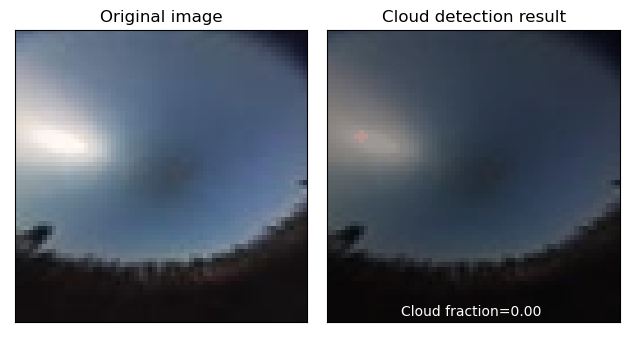

In [14]:
sample_num = 0
img = sky_images_sunny[sample_num]
#img = improve_image_brightness(img)
time_stamp = time_stamps_sunny[sample_num]
vis_single_img(time_stamp,img)

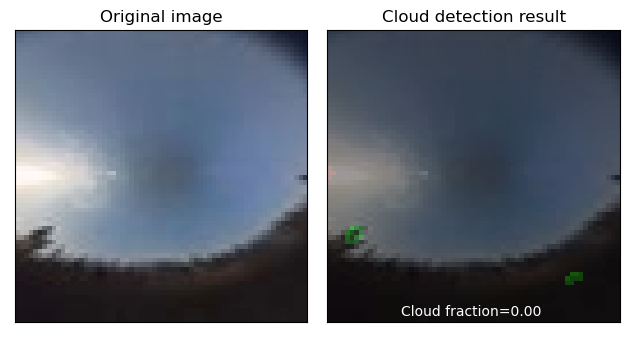

In [6]:
sample_num = 250
img = sky_images_sunny[sample_num]
img = improve_image_brightness(img)
time_stamp = time_stamps_sunny[sample_num]
vis_single_img(time_stamp,img)

### demo 2: cloud detection
Clouds are indicated by green pixels

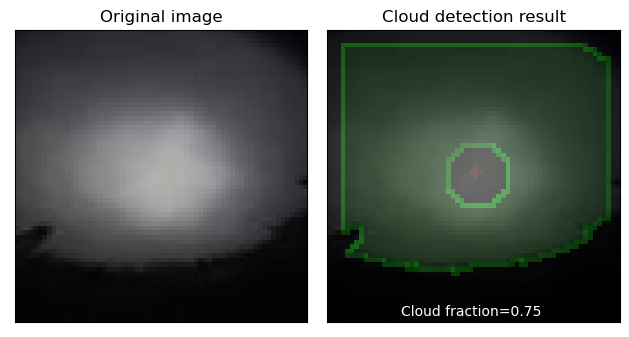

In [15]:
# demo 2: one sample from cloudy day
sample_num = 0
img = sky_images_cloudy[sample_num]
time_stamp = time_stamps_cloudy[sample_num]
vis_single_img(time_stamp,img)

## Demo image time series

In [8]:
def vis_img_ts(time_stamps,images):
    '''
    Visualization of cloud detection results for image time series
    Generating a video
    '''
    
    # define a images_overlay variable that store original images and cloud detection results
    images_overlay = np.zeros_like(images)
    cloud_cover_arr = np.zeros(len(time_stamps))
    
    # run cloud detection function and overlay results with original images 
    for i in range(len(time_stamps)):
        # run cloud_detection function
        cloud_cover, cloud_mask, sun_mask = cloud_detection_unwrapped(time_stamps[i],images[i])
        cloud_cover_arr[i] = cloud_cover

        # calculate the morphological gradient for cloud mask to draw the edge to the clouds
        kernel = np.ones((2,2), np.uint8)
        bound_cloud = cv2.morphologyEx(cloud_mask, cv2.MORPH_GRADIENT, kernel)

        alpha1=0.15
        images_overlay[i] = cv2.addWeighted(images[i], 1-alpha1, sun_mask[:,:,::-1], alpha1, 0)

        alpha2=0.1
        images_overlay[i] = cv2.addWeighted(images_overlay[i], 1 - alpha2, cloud_mask, alpha2, 0)
        
        alpha3=0.2
        images_overlay[i] = cv2.addWeighted(images_overlay[i], 1 - alpha3, bound_cloud, alpha3, 0)
    
    f, ax = plt.subplots(1,2)
    img_plot1 = ax[0].imshow(images[0,:,:,::-1])
    img_plot2 = ax[1].imshow(images_overlay[0,:,:,::-1])
    cloud_fraction_text = ax[1].text(0.25,0.025, '', color='white', transform=ax[1].transAxes)
    
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].set_title('Original image',fontsize=8)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].set_title('Cloud detection result',fontsize=8)

    f.tight_layout()

    def update(frame_idx):
        # Update the image data for each frame
        img_plot1.set_data(images[frame_idx,:,:,::-1])
        img_plot2.set_data(images_overlay[frame_idx,:,:,::-1])

        # Update text elements
        cloud_fraction_text.set_text('Cloud fraction={0:.2f}'.format(cloud_cover_arr[frame_idx]))

        return [img_plot1, img_plot2, cloud_fraction_text]

    # Create the animation
    ani = FuncAnimation(f, update, frames=len(time_stamps), interval=50, blit=True)
    
    plt.close(f)

    return ani

### demo 3: sun position identification 

In [9]:
dates_sunny = np.asarray([time.date() for time in time_stamps_sunny])
np.unique(dates_sunny)

array([datetime.date(2017, 5, 20), datetime.date(2017, 8, 19),
       datetime.date(2017, 10, 7)], dtype=object)

In [10]:
# select 1 sunny_day for demonstration of sun position identification algortihm
select_sunny_day = [datetime.date(2017, 8, 19)]

mask_select_sunny_day = np.zeros(len(time_stamps_sunny),dtype=bool)
for i in range(len(time_stamps_sunny)):
    if dates_sunny[i] in select_sunny_day:
        mask_select_sunny_day[i] = 1

time_stamps_select_sunny_day = time_stamps_sunny[mask_select_sunny_day]
sky_images_select_sunny_day = sky_images_sunny[mask_select_sunny_day]
print('time_stamps_select_sunny_day.shape:',time_stamps_select_sunny_day.shape)
print('sky_images_select_sunny_day.shape:',sky_images_select_sunny_day.shape)

time_stamps_select_sunny_day.shape: (599,)
sky_images_select_sunny_day.shape: (599, 64, 64, 3)


In [11]:
import matplotlib as mpl
mpl.rcParams['animation.ffmpeg_path'] = r'C:\Users\Claire\Desktop\A4\A4S8\ffmpeg\ffmpeg-7.1.1-essentials_build\bin\ffmpeg.exe'

import matplotlib.animation as animation
print(animation.writers.list())  # Vérifie encore
writer = animation.FFMpegWriter(fps=10)

['pillow', 'ffmpeg', 'ffmpeg_file', 'imagemagick', 'imagemagick_file', 'html']


In [17]:
# demo 3: sun position identification for one sunny day, sample image every 2 minutes to save time
ani = vis_img_ts(time_stamps_select_sunny_day[::2],sky_images_select_sunny_day[::2])
ani.save(os.path.join(output_folder,'cloud_detection_ts_sunny.mp4'), writer=writer, dpi =300)


In [18]:
Video(os.path.join(output_folder,'cloud_detection_ts_sunny.mp4'))

### demo 4: cloud detection

In [12]:
dates_cloudy = np.asarray([time.date() for time in time_stamps_cloudy])
np.unique(dates_cloudy)

array([datetime.date(2017, 5, 24), datetime.date(2017, 9, 6),
       datetime.date(2017, 12, 29)], dtype=object)

In [13]:
# select 1 cloudy_day for demonstration of cloud detection algorithm
select_cloudy_day = [datetime.date(2017, 5, 24)]
mask_select_cloudy_day = np.zeros(len(time_stamps_cloudy),dtype=bool)
for i in range(len(time_stamps_cloudy)):
    if dates_cloudy[i] in select_cloudy_day:
        mask_select_cloudy_day[i] = 1

time_stamps_select_cloudy_day = time_stamps_cloudy[mask_select_cloudy_day]
sky_images_select_cloudy_day = sky_images_cloudy[mask_select_cloudy_day]
print('time_stamps_select_cloudy_day.shape:',time_stamps_select_cloudy_day.shape)
print('sky_images_select_cloudy_day.shape:',sky_images_select_cloudy_day.shape)

time_stamps_select_cloudy_day.shape: (600,)
sky_images_select_cloudy_day.shape: (600, 64, 64, 3)


In [21]:
# demo 3: cloud detection for one cloudy day, sample image every 2 minutes to save time
ani = vis_img_ts(time_stamps_select_cloudy_day[::2],sky_images_select_cloudy_day[::2])
ani.save(os.path.join(output_folder,'cloud_detection_ts_cloudy.mp4'), dpi =300)

In [22]:
Video(os.path.join(output_folder,'cloud_detection_ts_cloudy.mp4'))

In [14]:
def plot_daily_pv_output(time_stamps_sunny, sunny_predictions, time_stamps_cloudy, cloudy_predictions):
    """
    Plot average PV output throughout the day for sunny and cloudy conditions.
    
    Parameters:
    -----------
    time_stamps_sunny : list or numpy.ndarray
        Timestamps for sunny images
    sunny_predictions : numpy.ndarray
        Predicted PV outputs for sunny images
    time_stamps_cloudy : list or numpy.ndarray
        Timestamps for cloudy images
    cloudy_predictions : numpy.ndarray
        Predicted PV outputs for cloudy images
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    plt.figure(figsize=(10, 6))
    
    # Get hour of day for each timestamp
    sunny_hours = np.array([t.hour + t.minute/60 for t in time_stamps_sunny])
    cloudy_hours = np.array([t.hour + t.minute/60 for t in time_stamps_cloudy])
    
    # Create bins for hours (from 6 AM to 8 PM)
    hour_bins = np.arange(6, 20, 1)
    
    sunny_means = []
    cloudy_means = []
    
    for i in range(len(hour_bins)-1):
        # Get predictions for this hour range
        sunny_mask = (sunny_hours >= hour_bins[i]) & (sunny_hours < hour_bins[i+1])
        cloudy_mask = (cloudy_hours >= hour_bins[i]) & (cloudy_hours < hour_bins[i+1])
        
        # Calculate mean if there are samples in this bin
        if np.sum(sunny_mask) > 0:
            sunny_means.append(np.mean(sunny_predictions[sunny_mask]))
        else:
            sunny_means.append(np.nan)
            
        if np.sum(cloudy_mask) > 0:
            cloudy_means.append(np.mean(cloudy_predictions[cloudy_mask]))
        else:
            cloudy_means.append(np.nan)
    
    # Plot hourly averages
    plt.plot(hour_bins[:-1] + 0.5, sunny_means, 'o-', label='Sunny')
    plt.plot(hour_bins[:-1] + 0.5, cloudy_means, 'o-', label='Cloudy')
    
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Predicted PV Output')
    plt.title('Average PV Output Throughout the Day')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.xlim(5.5, 19.5)
    plt.xticks(range(6, 20))
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

Training with 100 images...
Extracting features...
Generating synthetic PV outputs...
Training model...
Making predictions...
Visualizing results...


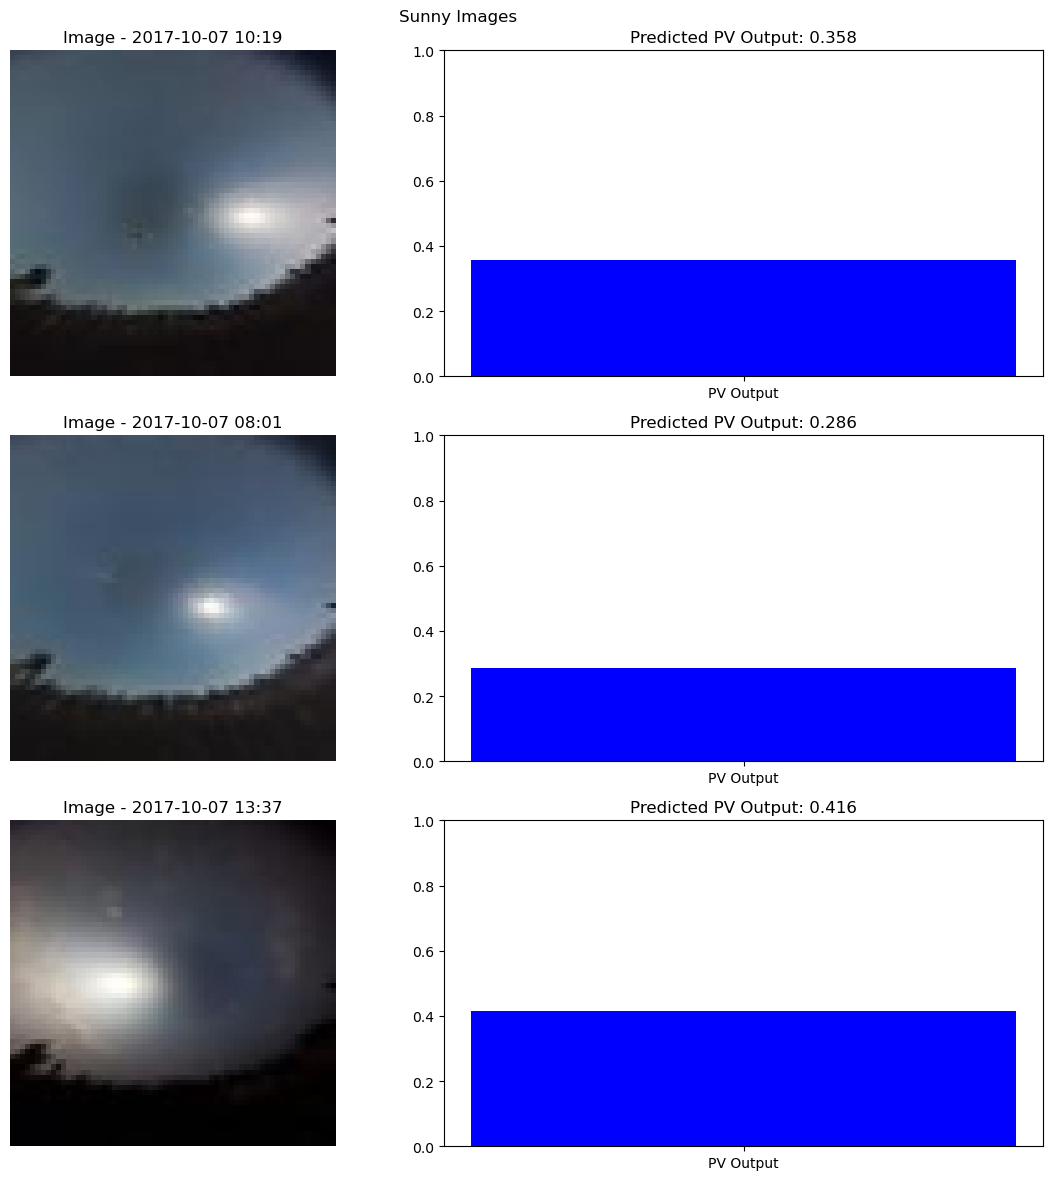

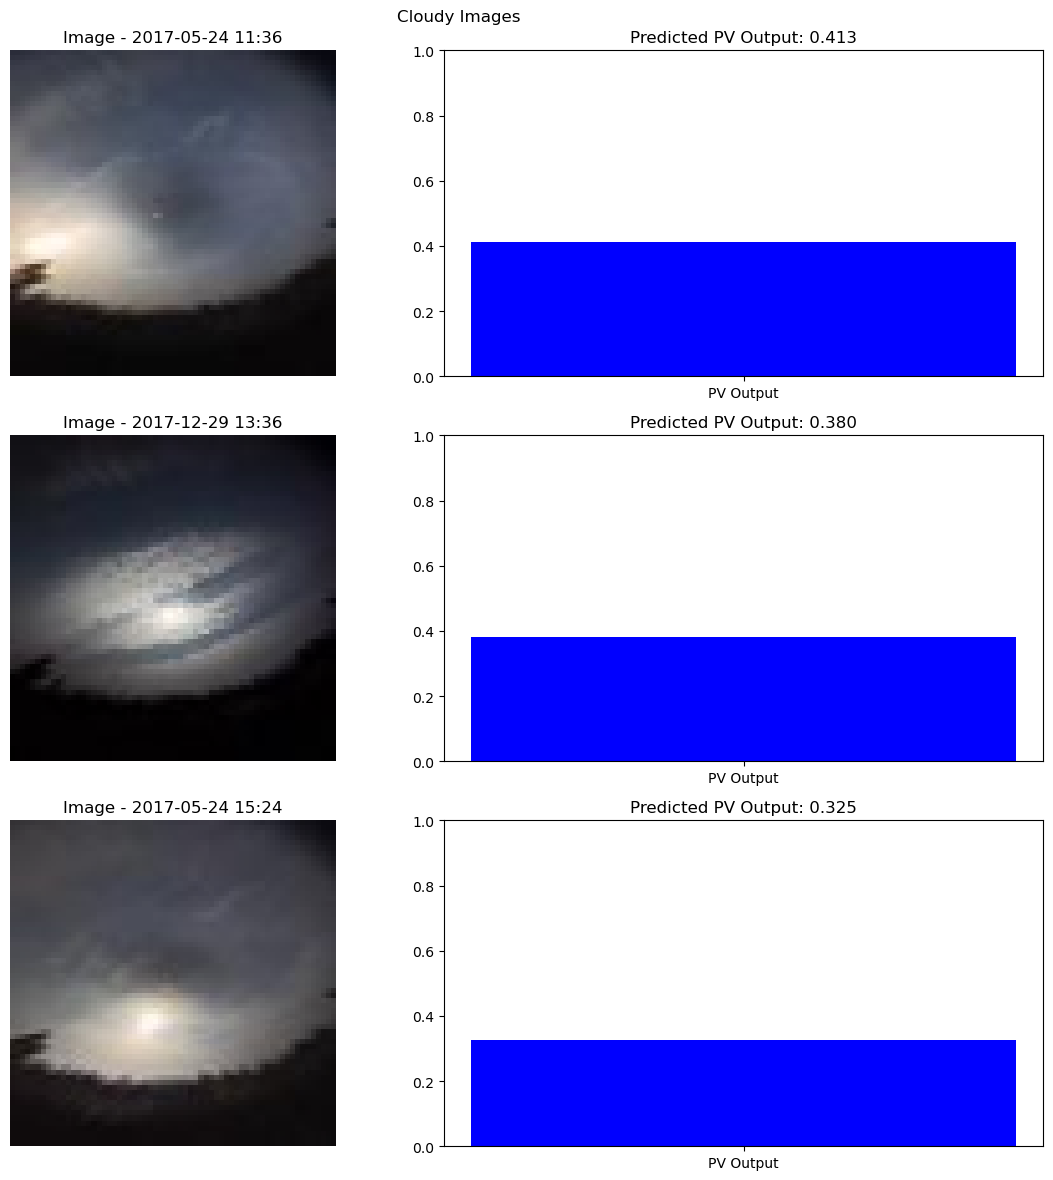

Average predicted PV output - Sunny: 0.4189, Cloudy: 0.3426


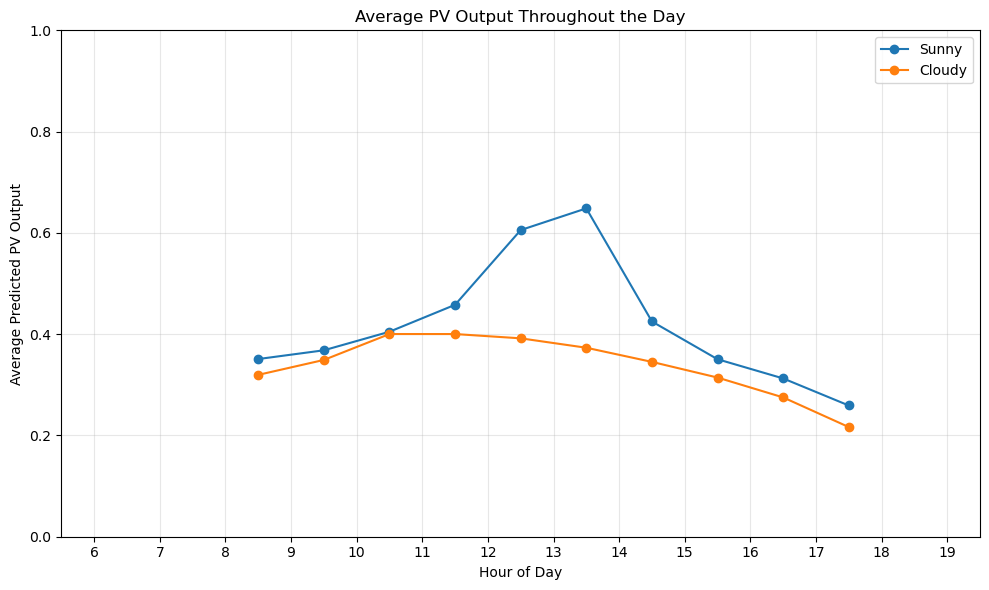

In [15]:

# Load your data here
# time_stamps_sunny = np.load(time_sunny_path, allow_pickle=True)
# sky_images_sunny = np.load(img_sunny_path, allow_pickle=True)
# time_stamps_cloudy = np.load(time_cloudy_path, allow_pickle=True)
# sky_images_cloudy = np.load(img_cloudy_path, allow_pickle=True)

# Train model and predict PV output
model, scaler, sunny_predictions, cloudy_predictions = process_and_predict_pv_output(
    sky_images_sunny, time_stamps_sunny, sky_images_cloudy, time_stamps_cloudy
)

# Plot average PV output throughout the day
plt.figure(figsize=(10, 6))

# Get hour of day for each timestamp
sunny_hours = np.array([t.hour + t.minute/60 for t in time_stamps_sunny])
cloudy_hours = np.array([t.hour + t.minute/60 for t in time_stamps_cloudy])

# Create bins for hours
hour_bins = np.arange(6, 20, 1)  # 6 AM to 8 PM
sunny_means = []
cloudy_means = []

for i in range(len(hour_bins)-1):
    # Get predictions for this hour range
    sunny_mask = (sunny_hours >= hour_bins[i]) & (sunny_hours < hour_bins[i+1])
    cloudy_mask = (cloudy_hours >= hour_bins[i]) & (cloudy_hours < hour_bins[i+1])

    # Calculate mean if there are samples in this bin
    if np.sum(sunny_mask) > 0:
        sunny_means.append(np.mean(sunny_predictions[sunny_mask]))
    else:
        sunny_means.append(np.nan)

    if np.sum(cloudy_mask) > 0:
        cloudy_means.append(np.mean(cloudy_predictions[cloudy_mask]))
    else:
        cloudy_means.append(np.nan)

# Plot hourly averages
plt.plot(hour_bins[:-1] + 0.5, sunny_means, 'o-', label='Sunny')
plt.plot(hour_bins[:-1] + 0.5, cloudy_means, 'o-', label='Cloudy')
plt.xlabel('Hour of Day')
plt.ylabel('Average Predicted PV Output')
plt.title('Average PV Output Throughout the Day')
plt.grid(True, alpha=0.3)
plt.legend()
plt.xlim(5.5, 19.5)  # 6 AM to 8 PM
plt.xticks(range(6, 20))
plt.ylim(0, 1)

plt.tight_layout()
plt.show()

In [16]:
def vis_img_ts_with_PV(time_stamps, images,model,scaler):
    '''
    Visualisation détection de nuages + PV + graphique temporel
    '''
    images_overlay = np.zeros_like(images)
    cloud_cover_arr = np.zeros(len(time_stamps))
    pv_output_arr = np.zeros(len(time_stamps))
    hours = np.zeros(len(time_stamps))
    
    for i in range(len(time_stamps)):
        # === Étape 1 : Détection des nuages ===
        cloud_cover, cloud_mask, _ = cloud_detection_unwrapped(time_stamps[i], images[i])
        cloud_cover_arr[i] = cloud_cover
        
        # === Étape 2 : Détection de la position du soleil ===
        sun_x, sun_y, sun_mask = detect_sun_in_unwrapped(images[i], time_stamps[i], original_params=None, search_radius=100)
        """
        # Assurer que sun_x, sun_y sont récupérés correctement
        if sun_x is None or sun_y is None:
            print(f"Problème avec la détection du soleil pour l'image {i}")
            sun_x, sun_y = images[i].shape[1] // 2, images[i].shape[0] // 2  # Position de secours
         """   
        # === Étape 3 : Distance soleil-nuage ===
        cloud_sun_dist = calculate_cloud_sun_distance(cloud_mask, sun_x, sun_y)
        
        # === Étape 4 : Heure du jour ===
        hour = time_stamps[i].hour + time_stamps[i].minute / 60.0
        hours[i] = hour
        
        # === Étape 5 : Prédiction de la production PV ===
        pv_output = predict_pv_output(model, scaler, images[i], time_stamps[i])
        pv_output_arr[i] = pv_output
        
        # Traitement d'images pour superposer les nuages et le soleil
        kernel = np.ones((2, 2), np.uint8)
        bound_cloud = cv2.morphologyEx(cloud_mask, cv2.MORPH_GRADIENT, kernel)
        
        alpha1 = 0.15
        images_overlay[i] = cv2.addWeighted(images[i], 1 - alpha1, sun_mask[:, :, ::-1], alpha1, 0)
        
        alpha2 = 0.1
        images_overlay[i] = cv2.addWeighted(images_overlay[i], 1 - alpha2, cloud_mask, alpha2, 0)
        
        alpha3 = 0.2
        images_overlay[i] = cv2.addWeighted(images_overlay[i], 1 - alpha3, bound_cloud, alpha3, 0)
        
    # === Création figure avec 3 sous-plots ===
    fig = plt.figure(figsize=(10, 4))
    gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 1.2])
    
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    ax3 = fig.add_subplot(gs[2])
    
    img_plot1 = ax1.imshow(images[0, :, :, ::-1])
    img_plot2 = ax2.imshow(images_overlay[0, :, :, ::-1])
    
    cloud_text = ax2.text(0.01, 0.025, '', color='white', transform=ax2.transAxes, fontsize=6)
    pv_text = ax2.text(0.01, 0.075, '', color='yellow', transform=ax2.transAxes, fontsize=6)
    
    for ax in [ax1, ax2]:
        ax.set_xticks([])
        ax.set_yticks([])
        
    ax1.set_title('Original', fontsize=8)
    ax2.set_title('Clouds + PV', fontsize=8)
    
    # === Courbe PV ===
    ax3.plot(hours, pv_output_arr, color='orange')
    vertical_line = ax3.axvline(hours[0], color='red', linestyle='--')
    
    ax3.set_xlim(hours.min(), hours.max())
    ax3.set_ylim(0, pv_output_arr.max() * 1.1)
    ax3.set_title('PV output (W/m²)', fontsize=8)
    ax3.set_xlabel('Heure')
    ax3.set_ylabel('PV')
    
    fig.tight_layout()
    
    def update(frame_idx):
        img_plot1.set_data(images[frame_idx, :, :, ::-1])
        img_plot2.set_data(images_overlay[frame_idx, :, :, ::-1])
        cloud_text.set_text(f'Cloud fraction: {cloud_cover_arr[frame_idx]:.2f}')
        pv_text.set_text(f'PV output: {pv_output_arr[frame_idx]:.1f} W/m²')
        vertical_line.set_xdata(hours[frame_idx])
        return [img_plot1, img_plot2, cloud_text, pv_text, vertical_line]
    
    ani = FuncAnimation(fig, update, frames=len(time_stamps), interval=50, blit=True)
    plt.close(fig)
    return ani

In [18]:
ani = vis_img_ts_with_PV(time_stamps_select_cloudy_day[::2], sky_images_select_cloudy_day[::2], model, scaler)
ani.save(os.path.join(output_folder, 'sunny.mp4'), writer=writer, dpi=300)
Video(os.path.join(output_folder, 'cloud_detection_cloudy_pv_ts.mp4'))
